# Assignment 4
Patrick Erath (260719203)

In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np 
import cv2
import time
from skimage import feature as ft
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Unpickle file - from documentation
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [2]:
# The dataset folder was renamed from 'CIFAR-10' to 'data' for readability

batch1_path = './data/data_batch_1'
names_path = './data/batches.meta'

try:
    batch_1 = unpickle(batch1_path)
    data_names = unpickle(names_path)
except Exception as e:
    print(e)
    
data_batch_1 = batch_1[b'data']
label_batch_1 = batch_1[b'labels']

test_path = './data/test_batch'
testing_set = unpickle(test_path)

test_data_raw = testing_set[b'data']
test_data = test_data_raw.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
test_indices = testing_set[b'labels']

## Convert to Images

Data Shape (10000, 3072)


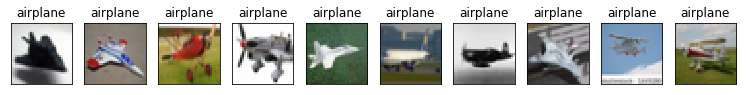

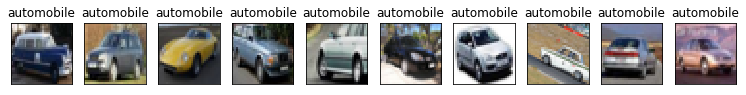

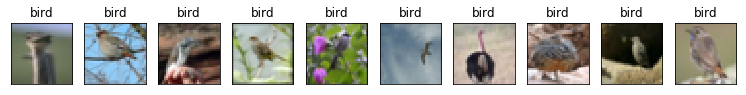

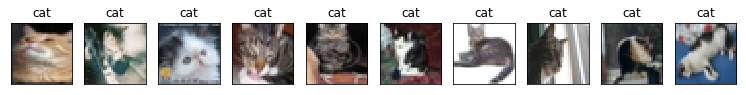

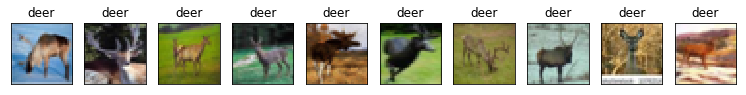

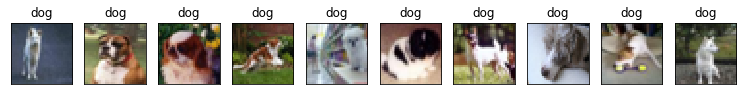

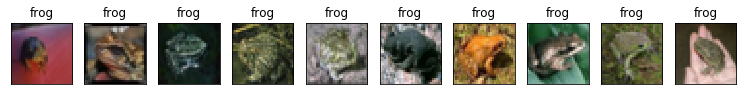

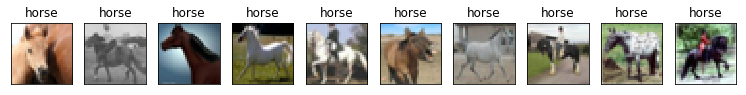

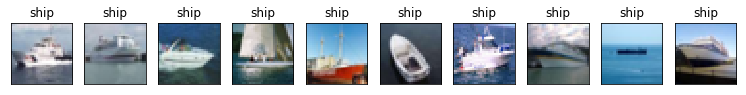

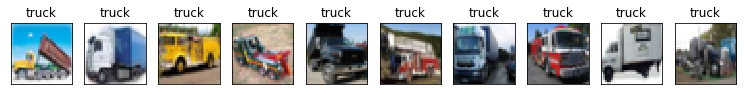

In [3]:
print('Data Shape', data_batch_1.shape)

# Reshape image such that it has RGB chanels for plotting
data_reshaped = data_batch_1.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
        
arr = [131, 132, 133]
index = 0
j=0
for i in range(10):
    counter = 0
    plt.figure(figsize=(13,13))
    while(counter != 10):
        if(label_batch_1[index] == i):
            plt.subplot(1,10,counter+1)
            plt.imshow(data_reshaped[index])
            plt.xticks([]), plt.yticks([])
            plt.title(str(data_names[b'label_names'][i].decode("utf-8")))
            counter += 1
            j += 1
        index += 1  
        
plt.show()

# 2.1 - Linear SVMs - Exploring Features

In [4]:
def draw_confusion(x, y, title='Confusion Matrix'):
    '''
    Draws confusion matrix
    '''
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(x, y)
    plt.figure(figsize=(5,5))
    plt.imshow(cm)
    plt.xticks([]), plt.yticks([])
    plt.title(str(title))
    plt.show()
    

def get_correct(predictions):
    '''
    Returns the number of correct predictions
    '''
    correct_n = 0
    for i in range(len(predictions)):
        if(predictions[i] == test_indices[i]):
            correct_n+=1
    return correct_n

def hog(imgs, bins=9, blocks=(8,8), cells=(2,2)):
    '''
    Returns hog feats array
    '''
    hog_feats = []
    for i in range(len(imgs)):
        image = imgs[i]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        x = ft.hog(gray, orientations=bins, pixels_per_cell=blocks,
                   cells_per_block=cells, block_norm='L2-Hys')
        hog_feats.append(x)
    return hog_feats    

# Linear SVM - HoG Features

Percentage Accuracy: 48.9%
Time taken for Linear-SVM-Hog: 33.46431612968445 seconds


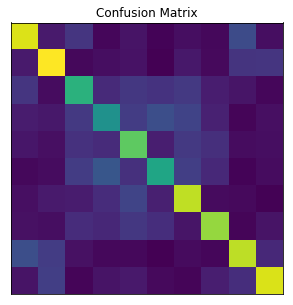

In [5]:
# Read in test data and get HoG feats
test = hog(test_data)    

# Read in training data and get HoG feats
train_x = hog(data_reshaped)

# Create CLF and fit data
clf = svm.SVC(gamma='scale', kernel='linear')
clf.fit(train_x, label_batch_1)

# Start timer for prediction model
start_time = time.time()

# Use clf to Predict the test data
predictions = clf.predict(test[:len(test)])

# End timer for model prediction 
end_time = time.time()

# Get number of correct predictons
correct_n = get_correct(predictions)

        
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")
print("Time taken for Linear-SVM-Hog: "+str(end_time-start_time)+" seconds")

# Get confusion matrix
draw_confusion(test_indices, predictions)

## Linear SVM - Mean Intensity Features

Percentage Accuracy: 24.05%
Time taken for Linear-SVM Mean-Intensity: 1.5044286251068115 seconds


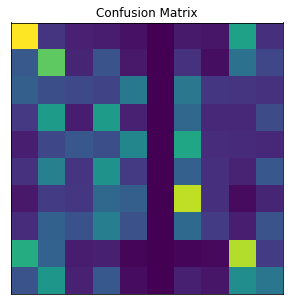

In [6]:
def mean_intensity_rgb(raw_data):
    '''
    Sum all the red, green and blue pixel values and divide by number of pixels to get
    mean red, mean green and mean blue values
    '''
    mean_feats = []
    for i in range(len(raw_data)):    
        rgb_sum = np.zeros(3)
        for j in range(3072):
            if(j<1024):
                rgb_sum[0] += raw_data[i][j]
            elif(j>=1024 and j<2048):
                rgb_sum[1] += raw_data[i][j]
            else:
                rgb_sum[2] += raw_data[i][j]
        mean_feats.append(rgb_sum/1024)
    return mean_feats


# Pass in the RAW data because it is already organized by RGB
mean_intensity_train = mean_intensity_rgb(data_batch_1)

# Pass in the RAW data because it is already organized by RGB
mean_intensity_test = mean_intensity_rgb(test_data_raw)

# Create CLF and fit data
clf_mean = svm.SVC(gamma='scale', kernel='linear')
clf_mean.fit(mean_intensity_train, label_batch_1)

# Start timer for model
start_time = time.time()

# Use clf to Predict the test data
predictions = clf_mean.predict(mean_intensity_test)

# End timer for model 
end_time = time.time()

# Get number of correct predictons
correct_n = get_correct(predictions)

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")
print("Time taken for Linear-SVM Mean-Intensity: "+str(end_time-start_time)+" seconds")

draw_confusion(test_indices, predictions)

## Comparing Mean Intensity and HoG Features

When comparing the peformance metrics using Mean Intensity and HoG as features for Linear SVM, it can be seen that HoG has a much better performance as a feature. Indeed, HoG has a accuracy of around 48.9% whereas Mean Intensity results in an accuracy of 24.05%. 

This is to be expected because Mean Intensity looses a significant amount of important data by turning 32x32x3 datapoints into 3 data points. Furthermore, mean intensity will fail in classifying animals which are completely different colors, as mean intensity relies solely on color (unlike HoG). 

As such, it can be stated hypothetically that both feature extraction methods would perform similary in which the objects to be classified had clear outlined shapes (for HoG) and clear different colors (for Mean Intensity). An example of this could be classifying Pine Trees VERSUS Rivers for example.

# 2.2 - Non-linear SVMs - Exploring Features

## Polynomial SVM - HoG feats

Percentage Accuracy: 54.94%
Time taken for Polynomial-SVM-Hog : 31.97755789756775 seconds


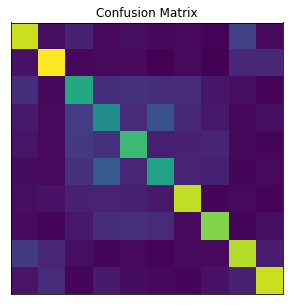

In [7]:
# Create Polynomial SVM
svm_polynomial = svm.SVC(kernel='poly', gamma='scale')

# Fit data
svm_polynomial.fit(train_x, label_batch_1)

# Start timer for model
start_time = time.time()

# Use clf to Predict the test data
predictions = svm_polynomial.predict(test[:len(test)])

# End timer for model 
end_time = time.time()

# Get number of correct predictons
correct_n = get_correct(predictions)
        
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")
print("Time taken for Polynomial-SVM-Hog : "+str(end_time-start_time)+" seconds")

# Get confusion matrix
draw_confusion(test_indices, predictions)

# Radial Basis Function SVM - HoG feats

Percentage Accuracy: 56.61000000000001%
Time taken for RBF-SVM-Hog: 80.08242893218994 seconds


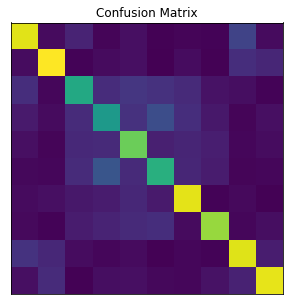

In [8]:
# Create Radial Basis Function (RBF) SVM
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# Start timer for model
start_time = time.time()

# Fit data
svm_rbf.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = svm_rbf.predict(test[:len(test)])

# End timer for model 
end_time = time.time()

# Get number of correct predictons
correct_n = 0
for i in range(len(predictions)):
    if(predictions[i] == test_indices[i]):
        correct_n+=1

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")
print("Time taken for RBF-SVM-Hog: "+str(end_time-start_time)+" seconds")

# Get confusion matrix
draw_confusion(test_indices, predictions)

## Comparing Non-linear and Linear SVMs

When comparing the linear and non-linear SVMs it can be seen that the linear SVMs performs worse than the non-linear SVMs. Indeed the linear SVM has an accuracy of 48.9% whereas the polynomial SVM has an accuracy of 54.94%. When comparing the Linear SVM and the Radical Basis Function (RBF) we also see that the RBF SVM performs better with an accuracy of 56.61%.

It makes sense intuitively that a non-linear kernel would perform better than a linear one because a linear forces a linear relationship whereas a non-linear is able to adapt to multiple different relationships. When comparing the Polynomial and RBF accuracies, it is also to be expected that RBF will perform better. This is because the polynomial kernel uses polynomial regression, whereas the rbf uses the squared Euclidean distance. 

# 3 Random Forest Classifiers

## 3.1 RF - Exploring Performance of HoG Features

Percentage Accuracy: 45.56%


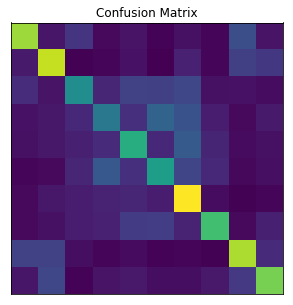

In [9]:
# Create Classifier
clf_rfc = RandomForestClassifier(n_estimators=100, criterion = 'entropy')

# Fit data
clf_rfc.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = clf_rfc.predict(test[:len(test)])

# Get number of correct predictons
correct_n = get_correct(predictions)

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

## 3.2 RF - Exploring Different Number of Trees

### Number of trees = 40

Percentage Accuracy: 40.89%


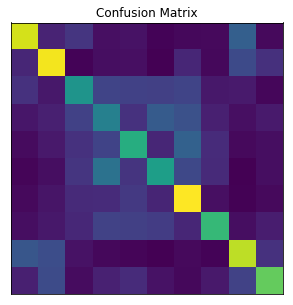

In [10]:
clf_rfc_30 = RandomForestClassifier(n_estimators=40, criterion = 'entropy')

clf_rfc_30.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = clf_rfc_30.predict(test[:len(test)])

# Get number of correct predictons
correct_n = get_correct(predictions)
        
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

### Numbert of trees = 200

Percentage Accuracy: 47.52%


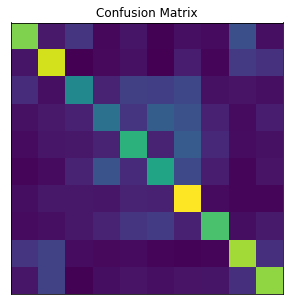

In [11]:
clf_rfc_200 = RandomForestClassifier(n_estimators=200, criterion = 'entropy')

clf_rfc_200.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = clf_rfc_200.predict(test[:len(test)])

# Get number of correct predictons
correct_n = get_correct(predictions)

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

### Number of Trees = 250

Percentage Accuracy: 48.55%


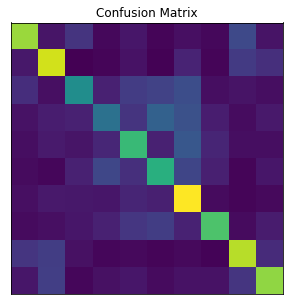

In [12]:
clf_rfc_250 = RandomForestClassifier(n_estimators=250, criterion = 'entropy')

clf_rfc_250.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = clf_rfc_250.predict(test[:len(test)])

# Get number of correct predictons
correct_n = get_correct(predictions)
    
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

## Number of Trees Versus Accuracy

As can be seen when looking at the above confusion matrices and accuracy values, increasing the number of trees increases the accuracy of prediction of our model. Indeed:
- RF with 40 trees Percentage Accuracy: 40.89%
- RF with 200 trees Percentage Accuracy: 47.52%
- RF with 250 trees Percentage Accuracy: 48.55%

Thus from the classification performance increases as the number of trees increases. The optimum number of trees found through trial and error was found to be 400 trees. The confusion matrix for this model is shown below. It should be noted that increasing the number of trees past this value results in a very low increase in accuracy, ie the accuracy reaches a asymptope.

# 4 Comparison of Classifiers 

## 4.1 Peformance Analysis 

As can be seen when looking at the evaluation metrics for SVM and for RF, the best performing RF classifier occurs for an RF with 250 trees. The best performing SVM occurs for a non-linear SVM with a RBF kernel.
- RBF-SVM-Hog : 56.61%
- RFC-250 trees : 48.55%

Measuring the accuracy and confusion matrices for both classifiers on the training set is shown below: 

### SVM Non-Linear with RBF Kernel

Percentage Accuracy: 81.75%


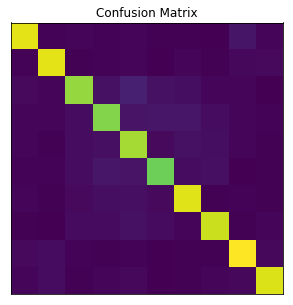

In [13]:
# Create Radial Basis Function (RBF) SVM
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# Fit data
svm_rbf.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = svm_rbf.predict(train_x)

# Get number of correct predictons
correct_n = 0
for i in range(len(predictions)):
    if(predictions[i] == label_batch_1[i]):
        correct_n+=1
        
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(label_batch_1, predictions)

### RF with 250 trees

Percentage Accuracy: 100.0%


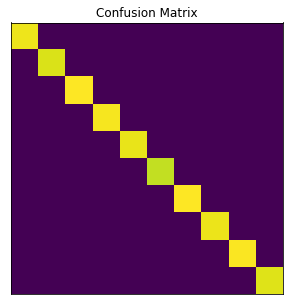

In [14]:
clf_rfc_250 = RandomForestClassifier(n_estimators=250, criterion = 'entropy')

clf_rfc_250.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = clf_rfc_250.predict(train_x)

# Get number of correct predictons
correct_n = 0
for i in range(len(predictions)):
    if(predictions[i] == label_batch_1[i]):
        correct_n+=1
        
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(label_batch_1, predictions)

### Observations 

When measuring the performance of the training set, it can be seen that the Random Forest Classifier has an accuracy of 100%, whereas the SVM Non-Linear RBF has an accurayc of 81.75%. 

When comparinf the <b>training</b> confusion matrices of RBF-SVM-Hog and RF it can be seen that the RF model results in a perfect fit when plugging the training data set back in. The RBF-SVM-Hog model however has a much lower accuracy, and has particular trouble detecting the indices 2, 3, 4 and 5 which correspond to 'birds', 'cats', 'deers' amd 'dogs' respectively.

When comparing the <b>testing</b> confusion matrices of RBF-SVM-Hog and RF, it can be seen that the SVM model seems to have particular trouble detecting labels 2 and 3 correspond to 'birds', 'cats'. The same is tue for the RF model, whos diagonal confusion matrix is also a light blue color at the indices 2 and 3. 

## 4.2 Exploring Different Parameters of HoG with SVM - RBF

<b>Experiment 1:</b>
- Orientation Bins = 9
- Cells per Block = 4, 4
- Pixels per Cell = 8, 8

Percentage Accuracy: 57.230000000000004%


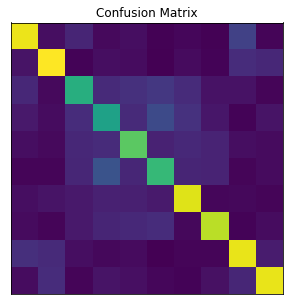

In [15]:
# Read in test data and get HoG feats
test = hog(test_data, bins=9, blocks=(8,8), cells=(4,4))

# Read in training data and get HoG feats
train_x = hog(data_reshaped, bins=9, blocks=(8,8), cells=(4,4))
    
# Create Radial Basis Function (RBF) SVM
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# Fit data
svm_rbf.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = svm_rbf.predict(test[:len(test)])

# Get number of correct predictons
correct_n = get_correct(predictions)
        
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

<b>Experiment 2:</b>
- Orientation Bins = 10
- Cells per Block = 2, 2
- Pixels per Cell = 8, 8

Percentage Accuracy: 56.04%


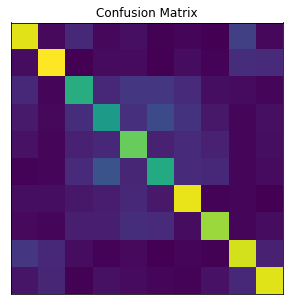

In [16]:
# Read in test data and get HoG feats
test = hog(test_data, bins=10, blocks=(8,8), cells=(2,2))

# Read in training data and get HoG feats
train_x = hog(data_reshaped, bins=10, blocks=(8,8), cells=(2,2))
    
# Create Radial Basis Function (RBF) SVM
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# Start timer for model
start_time = time.time()

# Fit data
svm_rbf.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = svm_rbf.predict(test[:len(test)])

# End timer for model 
end_time = time.time()

# Get number of correct predictons
correct_n = get_correct(predictions)
      
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

<b>Experiment 3:</b>
- Orientation Bins = 9
- Cells per Block = 2, 2
- Pixels per Cell = 4, 4

Percentage Accuracy: 46.88%


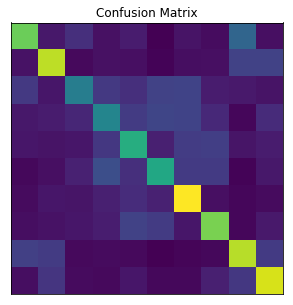

In [17]:
# Read in test data and get HoG feats
test = hog(test_data, bins=9, blocks=(16,16), cells=(2,2))

# Read in training data and get HoG feats
train_x = hog(data_reshaped, bins=9, blocks=(16,16), cells=(2,2))
    
# Create Radial Basis Function (RBF) SVM
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# Fit data
svm_rbf.fit(train_x, label_batch_1)

# Use clf to Predict the test data
predictions = svm_rbf.predict(test[:len(test)])

# Get number of correct predictons
correct_n = get_correct(predictions)

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

## Observations 

With our original RBF-SVM-HOG we had an accuracy of 56.61% with the following parameters:
- Orientation Bins = 9
- Cells per Block = 2, 2
- Pixels per Cell = 8, 8

In conclusion, by judging from the three above experiments, it can be determined that:
- Increasing the Cells Per Block from (2,2) to (4,4) increased the accuracy from 56.61% to 57.23% (Keeping all other parameters constant)
- Increasing the Orientation Bins from 9 to 10 decreased the accuracy from 56.61% to 56.04%. (Keeping all other parameters constant)
- Increasing the Pixels Per Cell from (8, 8) to (16, 16) decreased the accuracy from 56.61% to 46.88% (Keeping all other parameters constant)

It should be noted that it is difficult to find an exact relationship between increasing/decreasing this parameters and accuracy, because it is data dependent. Finding the perfect blocksize, cellsize and orientation bins is mostly dependent on the dataset. As such, the 'ideal' kernel from the above experiments was determined to be the following:
- Orientation Bins = 9
- Cells per Block = 4, 4
- Pixels per Cell = 8, 8

## 4.3 Folded Validation 

In [18]:
# Read in the three new data sets
batches_path = ['./data/data_batch_2', './data/data_batch_3', './data/data_batch_4']
batches = []
for i in range(len(batches_path)):
    batches.append(unpickle(batches_path[i]))
    
# Read in test set
test_path = './data/test_batch'
testing_set = unpickle(test_path)
test_data_raw = testing_set[b'data']
test_data = test_data_raw.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
test_indices = testing_set[b'labels']

# get HOG feats for each data set
batches_hog = []
for i in range(3):
    temp = batches[i][b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    batches_hog.append(hog(temp, bins=9, blocks=(8,8), cells=(4,4)))
    
# get HOG feats for test data set
test_hog = hog(test_data, bins=9, blocks=(8,8), cells=(4,4))

### SVM - Data Batch 2

Percentage Accuracy: 56.19%


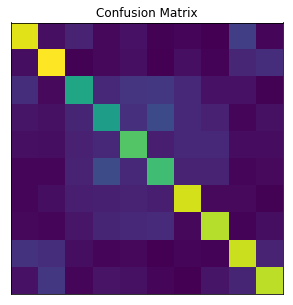

In [19]:
label_batch_2 = batches[0][b'labels']

# Create Radial Basis Function (RBF) SVM
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# Fit data
svm_rbf.fit(batches_hog[0], label_batch_2)

# Use clf to Predict the test data
predictions = svm_rbf.predict(test_hog)

# Get number of correct predictons
correct_n = get_correct(predictions)

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

### SVM - Data Batch 3

Percentage Accuracy: 56.48%


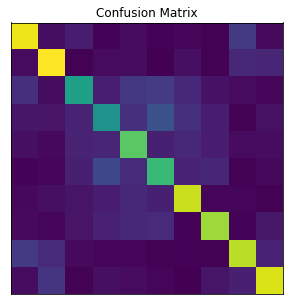

In [20]:
from sklearn.metrics import confusion_matrix

label_batch_3 = batches[1][b'labels']

# Create Radial Basis Function (RBF) SVM
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# Fit data
svm_rbf.fit(batches_hog[1], label_batch_3)

# Use clf to Predict the test data
predictions = svm_rbf.predict(test_hog)

# Get number of correct predictons
correct_n = get_correct(predictions)
        
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

### SVM - Data Batch 4

Percentage Accuracy: 56.720000000000006%


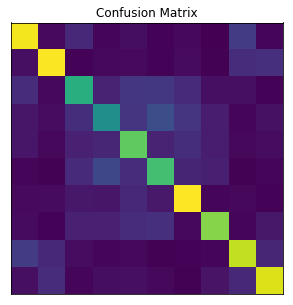

In [21]:
label_batch_4 = batches[2][b'labels']

# Create Radial Basis Function (RBF) SVM
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# Fit data
svm_rbf.fit(batches_hog[2], label_batch_4)

# Use clf to Predict the test data
predictions = svm_rbf.predict(test_hog)

# Get number of correct predictons
correct_n = get_correct(predictions)
        
print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions)

### RF - Data Batch 2

Percentage Accuracy: 48.69%


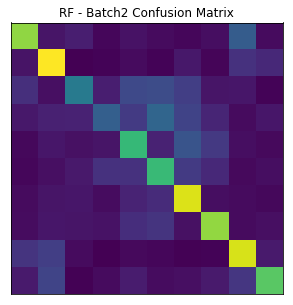

In [22]:
clf_rfc_250 = RandomForestClassifier(n_estimators=250, criterion = 'entropy')

# Fit clf with data
clf_rfc_250.fit(batches_hog[0], label_batch_2)

# Use clf to Predict the test data
predictions = clf_rfc_250.predict(test_hog)

# Get number of correct predictons
correct_n = get_correct(predictions)

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions, title='RF - Batch2 Confusion Matrix')

### RF - Data Batch 3

Percentage Accuracy: 48.41%


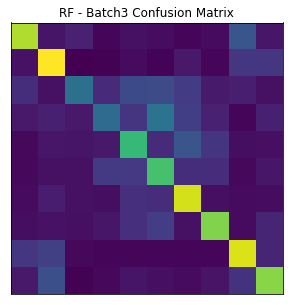

In [23]:
clf_rfc_250 = RandomForestClassifier(n_estimators=250, criterion = 'entropy')

# Fit clf with data
clf_rfc_250.fit(batches_hog[1], label_batch_3)

# Use clf to Predict the test data
predictions = clf_rfc_250.predict(test_hog)

# Get number of correct predictons
correct_n = get_correct(predictions)

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions, title='RF - Batch3 Confusion Matrix')

### RF - Data Batch 4

Percentage Accuracy: 48.77%


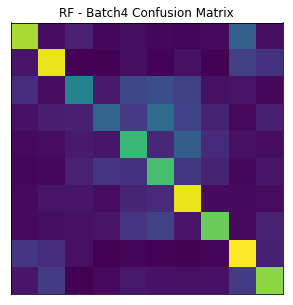

In [24]:
clf_rfc_250 = RandomForestClassifier(n_estimators=250, criterion = 'entropy')

# Fit clf with data
clf_rfc_250.fit(batches_hog[2], label_batch_4)

# Use clf to Predict the test data
predictions = clf_rfc_250.predict(test_hog)

# Get number of correct predictons
correct_n = get_correct(predictions)

print("Percentage Accuracy: " + str((correct_n/len(predictions))*100) + "%")

# Get confusion matrix
draw_confusion(test_indices, predictions, title='RF - Batch4 Confusion Matrix')

1) SVM with kernel=rbf and ideal HoG kernel:
- Batch 1: 57.23% (Original Dataset)
- Batch 2: 56.19%
- Batch 3: 56.48%
- Batch 4: 56.72%

2) Random Forest Classifier with number_trees=250
- Batch 1: 48.55%   (Original Dataset)
- Batch 2: 48.69%
- Batch 3: 48.41%
- Batch 4: 48.77%

It can be seen when comparing the accuracies of different data sets, that they are more or less within the same range for SVM and RF respectively. Nonethless, it can be seen that in the case of SVM Data Batch 1 results in the highest testing accuracy, whereas in the case of RF Data Batch 3 results in the highest test accuracy. 

The reason for a certain batch resulting a more accurate model could be for that the given data batch contains images which are very close to the testing images. This would result in a certain dataset being more accurate than another data set. Furthermore, depending on the model used (SVM or RF), the dataset provided can be perform better or worse. As such, it is possible that some data sets result in better models in one scenario than another. 

# 4.4 Ensemble Classifiers

Percentage Accuracy: 55.86%


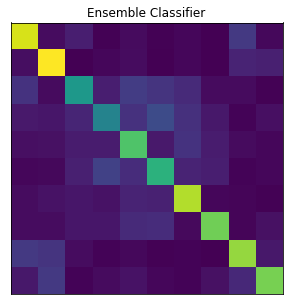

In [25]:
# Implementation of Ensemble Classifier was done as follows:
# Take most frequently occuring label of 6 classifier
def ensemble_classifier(c1, c2, c3, c4, c5, c6, tests):
    '''
    Finds the most often occuring value for each prediction label
    '''
    p1 = c1.predict(tests)
    p2 = c2.predict(tests)
    p3 = c3.predict(tests)
    p4 = c4.predict(tests)
    p5 = c5.predict(tests)
    p6 = c6.predict(tests)
    
    # Create a temporary array of each classifiers prediction (0-9) for image i
    # Let the most often occuring value in this temp array be the final prediction p
    p = []
    for i in range(len(tests)):
        temp = np.array([p1[i], p2[i], p3[i], p4[i], p5[i], p6[i]])
        counts = np.bincount(temp)
        p.append(np.argmax(counts))
    
    return p
    
    
# Create Radial Basis Function (RBF) SVM for datasets 2, 3 and 4
p1 = svm.SVC(kernel='rbf', gamma='scale')
p1.fit(batches_hog[0], label_batch_2)


p2 = svm.SVC(kernel='rbf', gamma='scale')
p2.fit(batches_hog[1], label_batch_3)

p3 = svm.SVC(kernel='rbf', gamma='scale')
p3.fit(batches_hog[2], label_batch_4)

# Create RF SVM for dataset 2, 3 and 4
p4 = RandomForestClassifier(n_estimators=250, criterion = 'entropy')
p4.fit(batches_hog[0], label_batch_2)

p5 = RandomForestClassifier(n_estimators=250, criterion = 'entropy')
p5.fit(batches_hog[1], label_batch_3)

p6 = RandomForestClassifier(n_estimators=250, criterion = 'entropy')
p6.fit(batches_hog[2], label_batch_4)

ensemble_prediction = ensemble_classifier(p1, p2, p3, p4, p5, p6, test_hog)
correct_n = get_correct(ensemble_prediction)

print("Percentage Accuracy: " + str((correct_n/len(ensemble_prediction))*100) + "%")

draw_confusion(test_indices, ensemble_prediction, title='Ensemble Classifier')

An ensemble classifier is extremely useful when the classifiers that it combines account for each others errors. As such, it is not useful for an ensemble classifier to combine two classifiers who both fail at predicting a cat but are extremely accurate at predicting ships for example. 

Initially, the ensemble classifier I implemented performed poorly because it took the average of the 6 classifiers prediction. This resulted in a poor prediction because outliers would cause the prediction to be slightly off numerically which would result in an inaccurate prediction.

The above ensemble classifier takes the most frequently occuring label between the 6 classifiers for each prediction, and hence performs better. This results in an accuracy of 55.86% which is virtually the same as the best performing RBF tree, and 2% poorer than the SVM with kernel=rbf and ideal HoG kernel classifier. The reason the ensemble classifier doesn't perform better than the other classifiers is because the classifiers don't account for each others errors (ie one classifier isn't very good at classifying cats and the other very good at classifying dogs). Furthermore, if all the RBF classifiers make a mistake in predicting a certain image, than this will be the most often occuring value which will hence result in the ensemble classifier also making a mistake